<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

_Author: Unknown_

-----

One of the most common applications for ARIMA models is inventory planning. In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# often necessary b/c pandas & statsmodels datetime issue
import warnings
warnings.simplefilter(action="ignore")

### Importing and exploring the data

After importing, check the following:
- Is there any missing data?
- What are the column datatypes?
- How many observations are there?
- How many unique stores are there?
- How many unique departments are there?

In [2]:
walmart = pd.read_csv('datasets/train.csv')
walmart.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False


In [3]:
#Is there any missing data?
walmart.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [4]:
#What are the column datatypes?
walmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [5]:
#How many observations are there?
walmart.shape[0]

421570

In [6]:
#How many unique stores are there?
walmart['Store'].nunique()

45

In [7]:
#How many unique departments are there?
walmart['Dept'].nunique()

81

**Getting weekly sales for store 1**

To simplify our work somewhat, we'll consider **only** sales from store 1, and we'll aggregate sales from all departments in store 1.

Create a new dataframe that contains weekly sales for store 1.

> **Note**: You might break this up into multiple steps, or you might do this in one line.
>
> To aggregate, use **groupby**. We're tallying up all sales that have the same date, _not_ aggregating many dates based on year or month.
>
> The only column you'll need to keep is `Weekly_Sales`. You should get rid of the `Store`, `Dept`, and `IsHoliday` columns in your new dataframe.

In [8]:
store_1 = walmart[walmart['Store']==1]

In [9]:
store_1 = store_1.groupby('Date', as_index=False)['Weekly_Sales'].sum()

In [10]:
store_1 

,Date,Weekly_Sales
0,2010-02-05,1643690.90
1,2010-02-12,1641957.44
2,2010-02-19,1611968.17
3,2010-02-26,1409727.59
4,2010-03-05,1554806.68
...,...,...
138,2012-09-28,1437059.26
139,2012-10-05,1670785.97
140,2012-10-12,1573072.81
141,2012-10-19,1508068.77


**Creating a datetime index**

Convert the `Date` column to datetime, and set it as the index for the dataframe.

In [11]:
# change date column to datetime object
store_1 ['Date'] = pd.to_datetime(store_1 ['Date'] )

In [12]:
# Set index to be the date column as a DatetimeIndex
store_1 .set_index('Date', inplace= True)
store_1.head(10)

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68
2010-03-12,1439541.59
2010-03-19,1472515.79
2010-03-26,1404429.92
2010-04-02,1594968.28


---

### Plotting and interpreting a time series

**Generate a line plot**

Generate a line plot for weekly sales, with time on the $x$-axis and sales on the $y$-axis. Make sure the plot has a title, and make sure axes are labeled where appropriate.

In [13]:
#function to plot graph
def plot_series(df, cols=None, title='Title', xlab=None, 
                ylab=None, steps=1):
    
    # Set figure size to be (18, 9)
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name
    for col in cols:
            
        # Generate a line plot of the column name
        # You only have to specify Y, since our
        # index will be a datetime index
        plt.plot(df[col])
        
    # Generate title and labels
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=12);

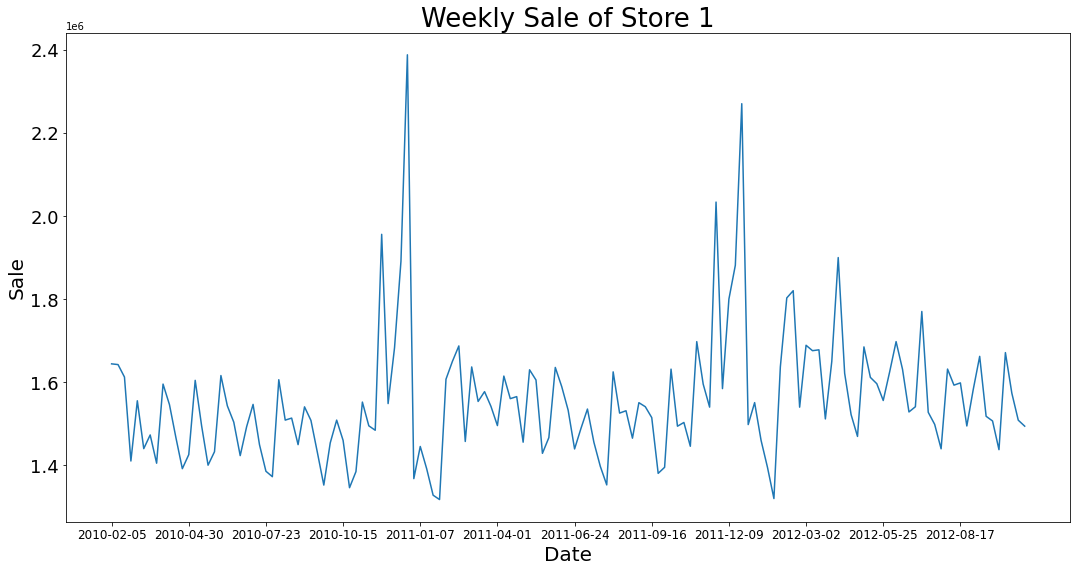

In [14]:
plot_series(store_1, cols=['Weekly_Sales'], title='Weekly Sale of Store 1', xlab='Date', 
                ylab='Sale', steps=12)

**Plotting rolling means**

Smoothing can help us see trends in the data. On one graph, plot the following:

- Weekly sales
- The 4-week rolling mean of weekly sales
- The 13-week rolling mean of weekly sales
    - (This is included because there are 13 weeks in a business quarter!)

Make sure the plot has a title, axis labels where appropriate, and a legend.

> **(BONUS)**: Add vertical lines on the plot to indicate January 2011 and January 2012.

In [15]:
import datetime as dt

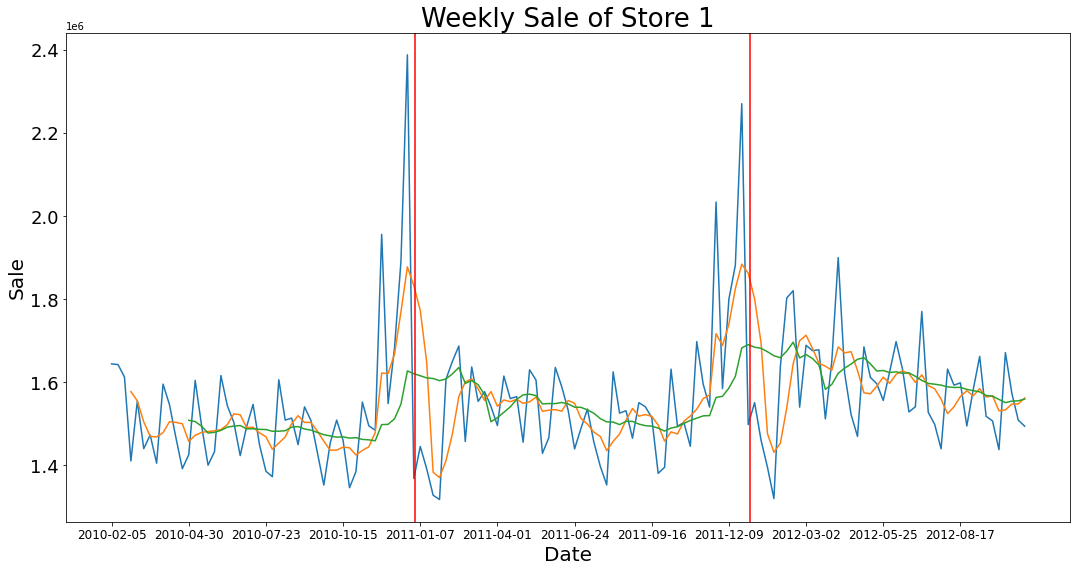

In [16]:
plot_series(store_1, cols=['Weekly_Sales'], title='Weekly Sale of Store 1', xlab='Date', ylab='Sale', steps=12) #weekly sale
plt.plot(store_1['Weekly_Sales'].rolling(4).mean()) # orange line : The 4-week rolling mean of weekly sales
plt.plot(store_1['Weekly_Sales'].rolling(13).mean()); #green line: The 13-week rolling mean of weekly sales
#plt.axvline(x = 2011-1-1, color = 'b', label = 'axvline - full height')
plt.axvline(dt.datetime(2011, 1, 1), color='r')
plt.axvline(dt.datetime(2012, 1, 1), color='r');

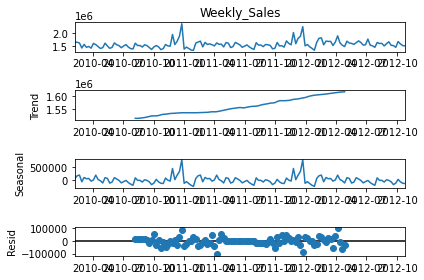

In [17]:
# Generate a decomposition plot of the airline passengers data
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(store_1['Weekly_Sales']).plot();

**Describe any trends that you notice**

In [18]:
# there seem to be slightly increasing trend. There seem to be systematic spike of weekly sales every year arounf January or February. 

---

### Autocorrelation and partial autocorrelation

Recall that autocorrelation and partial autocorrelation tell us about how a variable is related to itself at previous lags.

**Plot and interpret the autocorrelation**

Use statsmodels to plot the ACF and PACF. Look at up to **52 lags**. 

What do you notice? Provide a written answer along with your ACF/PACF plots below.

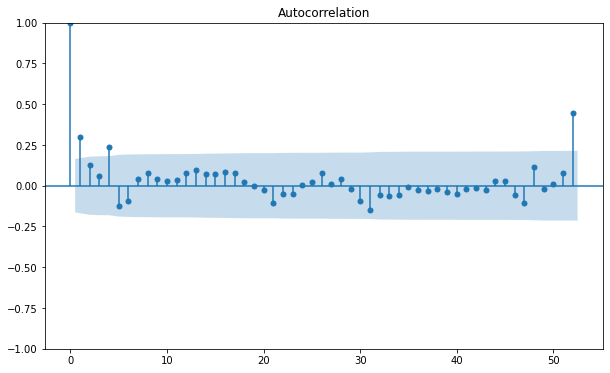

In [19]:
#Autocorrelation
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(store_1['Weekly_Sales'], lags =52, ax=ax);

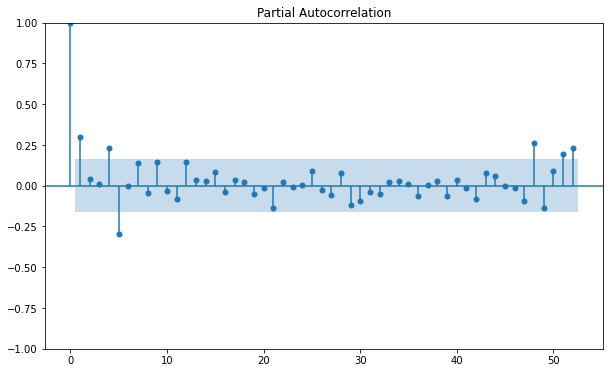

In [20]:
#partial autocorrelation
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(store_1['Weekly_Sales'], method='ywm', lags =52, ax=ax);

In [ ]:
#According to  ACF graph, at week 52, there is significant relationship to the first three weeks. This shows that the weekly sales might be seasonal data. 

---

### Modeling

**Train-test splitting**

Before fitting a model, we should train-test split. Use the first 90% of observations as training data, and use the remaining 10% as testing data. Remember -- we **do not need to shuffle the data**!

In [21]:
# Create train-test split
y_train, y_test = train_test_split(store_1['Weekly_Sales'], 
                                               test_size=0.1, 
                                               shuffle= False)

In [24]:
y_train.shape, y_test.shape

((128,), (15,))

In [22]:
y_train.tail()

Date
2012-06-15    1630607.00
2012-06-22    1527845.81
2012-06-29    1540421.49
2012-07-06    1769854.16
2012-07-13    1527014.04
Name: Weekly_Sales, dtype: float64

In [23]:
y_test.head()

Date
2012-07-20    1497954.76
2012-07-27    1439123.71
2012-08-03    1631135.79
2012-08-10    1592409.97
2012-08-17    1597868.05
Name: Weekly_Sales, dtype: float64

**Evaluating stationarity**

Use the augmented Dickey-Fuller test to evaluate the weekly sales data, and interpret the result.

In [25]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], 
                         index=['Test Statistic','p-value'])
    return dfoutput

In [26]:
interpret_dftest(adfuller(store_1['Weekly_Sales']))

Test Statistic   -5.102186
p-value           0.000014
dtype: float64

In [ ]:
#the p-value is smaller than alpha = 0.01, thus we conclude that the data is stationary

---

**Fit and evaluate an AR(1) model**

We'll start with a simple autoregressive model with order 1. In statsmodels, an autoregressive model with order $p=1$ can be implemented by instantiating and fitting an ARIMA model with order $(1,0,0)$.

Instantiate and fit your model on the training data.

In [29]:
 #fitting an ARIMA model with order  (1,0,0) 
arima = ARIMA(endog=y_train, order=(1, 0, 0))

# Fit ARIMA model
model =  arima.fit()

#AIC score
model.aic

3427.846294947587

### Evaluating the model

**Store predictions**

Remember that statsmodels ARIMA models generate predictions off of `start` and `end` dates.

Generate and store predictions for the training and testing data.

In [31]:
# Generate predictions based on test set
preds = model.predict(start=y_test.index[0], end=y_test.index[-1])

**Mean squared error**

Use the `mean_squared_error` function to identify the MSE on the testing data.

In [35]:
# Calculate MSE.
mse = mean_squared_error(y_test, preds)
print(f'MSE: {mse}')

MSE: 5188882502.605215


**Generate a plot of the training data, testing data, train preds, and test preds**

Create a plot showing the training data, testing data, train preds, and test preds. Make sure there are labels and legends.

> **Note**: You'll be making more similar plots. You might consider writing a function to generate your plots!

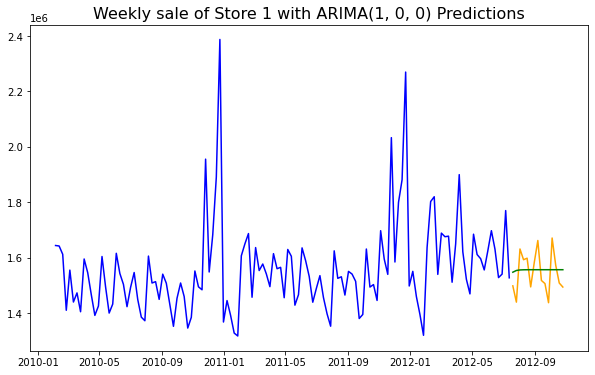

In [36]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data
plt.plot(y_train.index, pd.Series(y_train), color = 'blue')

# Plot testing data
plt.plot(y_test.index, pd.Series(y_test), color = 'orange')

# Plot predicted test values
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Weekly sale of Store 1 with ARIMA(1, 0, 0) Predictions', 
          fontsize=16)
plt.show();

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

The MSE is very high indicating that the performance of this model is not good. Moreover, the predicting graph show that the predicted weekly sales from the model are far off from the real values. 

---

**Fit and evaluate an ARMA(2,2) model**

In statsmodels, an autoregressive moving average model with order $p=2$, $q=2$ can be implemented by instantiating and fitting an ARIMA model with order $(2,0,2)$.

Instantiate and fit your model on the training data:

In [37]:
 #fitting an ARIMA model with order  (1,0,0) 
arima2 = ARIMA(endog=y_train, order=(2, 0, 2))

# Fit ARIMA model
model2 =  arima2.fit()

#AIC score
model2.aic

3414.9851073562804

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [38]:
# Generate predictions based on test set
preds2 = model2.predict(start=y_test.index[0], end=y_test.index[-1])

**Mean squared error**

Find the MSE of the testing data.

In [39]:
# Calculate MSE.
mse2 = mean_squared_error(y_test, preds2)
print(f'MSE: {mse2}')

MSE: 4617987711.367902


**Generate a plot of the training data, testing data, train preds, and test preds**

As before, plot your data and predictions.

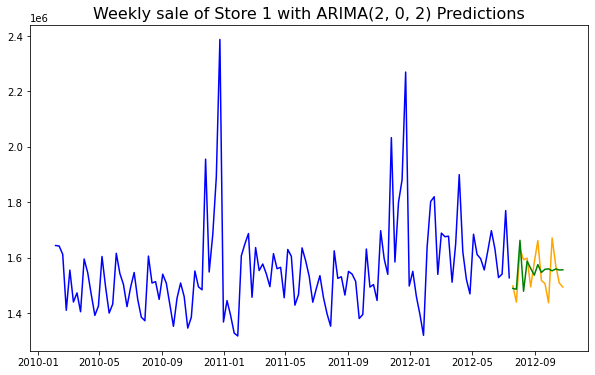

In [40]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data
plt.plot(y_train.index, pd.Series(y_train), color = 'blue')

# Plot testing data
plt.plot(y_test.index, pd.Series(y_test), color = 'orange')

# Plot predicted test values
plt.plot(y_test.index, preds2, color = 'green')

plt.title(label = 'Weekly sale of Store 1 with ARIMA(2, 0, 2) Predictions', 
          fontsize=16)
plt.show();

**Intepretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [ ]:
#The AIC scores and MSE are improve from the first model. According to the graph of predition, the predictd weekly sale value more accurate only 
#a few predictions and then the prediction become inaccurate and regresses to the mean 

---

**Fit and evaluate an ARIMA(2,1,2) model**

Instantiate and fit an ARIMA model with order $(2,1,2)$.

In [41]:
 #fitting an ARIMA model with order  (2, 1, 2) 
arima3 = ARIMA(endog=y_train, order=(2, 1, 2))

# Fit ARIMA model
model3 =  arima3.fit()

#AIC score
model3.aic

3425.8447997944586

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [42]:
# Generate predictions based on test set
preds3 = model3.predict(start=y_test.index[0], end=y_test.index[-1])

**Mean squared error**

Find the MSE on your testing data.

In [43]:
# Calculate MSE.
mse3 = mean_squared_error(y_test, preds3)
print(f'MSE: {mse3}')

MSE: 8383610277.922531


**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

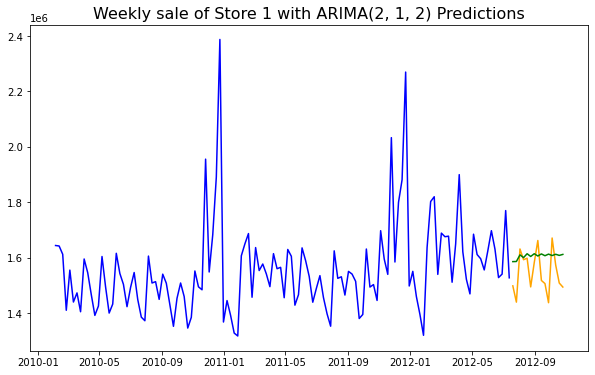

In [44]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data
plt.plot(y_train.index, pd.Series(y_train), color = 'blue')

# Plot testing data
plt.plot(y_test.index, pd.Series(y_test), color = 'orange')

# Plot predicted test values
plt.plot(y_test.index, preds3, color = 'green')

plt.title(label = 'Weekly sale of Store 1 with ARIMA(2, 1, 2) Predictions', 
          fontsize=16)
plt.show();

#### Interpretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [ ]:
#The performance of this model is worse than the second model, as we can see that the AIC scores and MSE are worse from the second model model. 
#According to the graph of predition, the predictd weekly sale values are less accurate. The predicted values are relatively straight line.

---

### Fit and evaluate an ARIMA(52,0,1) model

The models above use few autoregressive terms and don't do a good job of capturing the long-term trends that we know exist.

Instantiate and fit an ARIMA of order $(52,0,1)$.

In [45]:
 #fitting an ARIMA model with order  (52, 0, 1) 
arima4 = ARIMA(endog=y_train, order=(52, 0, 1) )

# Fit ARIMA model
model4 =  arima4.fit()

#AIC score
model4.aic

3394.84138144602

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [47]:
4# enerate predictions based on test set
preds4 = model4.predict(start=y_test.index[0], end=y_test.index[-1])

**Mean squared error**

Find the MSE on your testing data.

In [50]:
# Calculate MSE.
mse4 = mean_squared_error(y_test, preds4)
print(f'MSE: {mse4}')

MSE: 7894141328.787904


**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

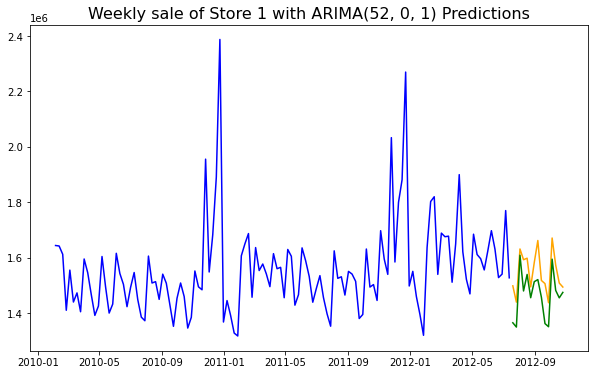

In [51]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data
plt.plot(y_train.index, pd.Series(y_train), color = 'blue')

# Plot testing data
plt.plot(y_test.index, pd.Series(y_test), color = 'orange')

# Plot predicted test values
plt.plot(y_test.index, preds4, color = 'green')

plt.title(label = 'Weekly sale of Store 1 with ARIMA(52, 0, 1) Predictions', 
          fontsize=16)
plt.show();

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [ ]:
#The performance of this model is better than previous models, as we can see that the AIC scores and MSE are better than previous models. 
#According to the graph of predition, the predictd weekly sale values are more accurate. The predicted values are relatively mimic the trend of  true values.

---

### SARIMA Modeling

Because of the seasonality of this data, a **seasonal** ARIMA model will perform more strongly.

A SARIMA model has an ARIMA portion which behaves as we expect it to. The S part of a SARIMA model allows us to use seasonal terms. The seasonal part of a SARIMA has order $(P, D, Q)_{m}$. $m$ is the **seasonal period** -- the number of observations per season. $P$, $D$, and $Q$ are somewhat similar to the $p$, $d$, and $q$ terms in an ARIMA model, but $P$, $D$, and $Q$ actually backshift by $m$. 

You can read more about SARIMA models here:
- [PennState SARIMA notes](https://online.stat.psu.edu/stat510/lesson/4/4.1)
- [Forecasting: Principles and Practice 3rd ed.](https://otexts.com/fpp3/seasonal-arima.html)

Fit and evaluate a SARIMA model with order $(2,0,2)$ and seasonal order $(1,1,1,52)$. How well does it perform?

> **Note**: SARIMA models are implemented in statsmodels as SARIMAX - the 'X' part allows [exogenous data](https://en.wikipedia.org/wiki/Exogenous_and_endogenous_variables) to be passed in as well, though we won't specify any.
>
> The seasonal order argument is `seasonal_order`.

In [53]:
# Fit a SARIMA(2, 0, 2) x (1, 1, 1, 52) model.
# Fit a SARIMA(p, d, q) x (P, D, Q, S) model.

sarima = SARIMAX(endog=y_train,
                 order=(2, 0, 2) , # (p, d, q)
                 seasonal_order = (1, 1, 1, 52)) # (P, D, Q, S)

# Fit SARIMA model
model5 = sarima.fit(disp=0)


preds5 = model5.predict(start=y_test.index[0], end=y_test.index[-1])

# Evaluate predictions
pd.options.display.float_format = '{:.2f}'.format
print(f"MSE: {mean_squared_error(y_test, preds5)}")
print(f"RMSE: {mean_squared_error(y_test, preds5, squared=False)}")



MSE: 1889258289.2084227
RMSE: 43465.59891694146


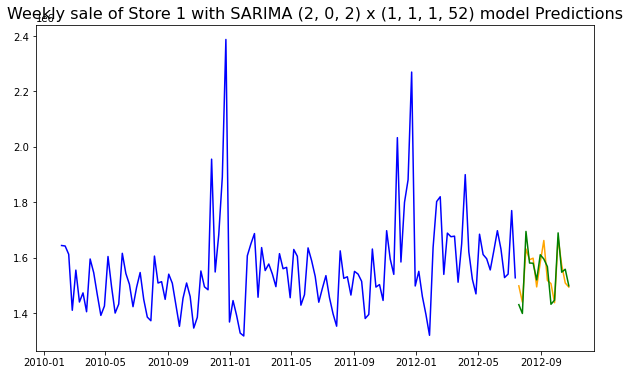

In [54]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data
plt.plot(y_train.index, pd.Series(y_train), color = 'blue')

# Plot testing data
plt.plot(y_test.index, pd.Series(y_test), color = 'orange')

# Plot predicted test values
plt.plot(y_test.index, preds5, color = 'green')

plt.title(label = 'Weekly sale of Store 1 with SARIMA (2, 0, 2) x (1, 1, 1, 52) model Predictions', 
          fontsize=16)
plt.show();

In [ ]:
#The performance of this model is best among previous models, as we can see that the AIC scores and MSE are better than previous models. 
#According to the graph of predition, the predictd weekly sale values are more accurate. The predicted values are accurately mimic the trend of true values.